# Implement a Radial Basis Function (RBF) Network to classify ancient Japanese characters from the Kuzushiji dataset.

## Data Preparation:

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

dataset, info = tfds.load('kmnist', with_info=True, as_supervised=True)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Extract train and test data
train_data, test_data = dataset['train'], dataset['test']

# Convert to numpy arrays and normalize the pixel values
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize between 0 and 1
    return tf.reshape(image, (-1,)), label      # Flatten the image

train_data = train_data.map(preprocess)
test_data = test_data.map(preprocess)

# Convert to batches
train_images = []
train_labels = []
for image, label in train_data:
    train_images.append(image.numpy())
    train_labels.append(label.numpy())

test_images = []
test_labels = []
for image, label in test_data:
    test_images.append(image.numpy())
    test_labels.append(label.numpy())

# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Split into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print("Training data shape: ", X_train.shape)
print("Validation data shape: ", X_val.shape)

Training data shape:  (48000, 784)
Validation data shape:  (12000, 784)


## Radial Basis Function (RBF) Network:

In [ ]:
class RBFNetwork:
    def __init__(self, num_centers, num_outputs):
        self.num_centers = num_centers
        self.num_outputs = num_outputs
        # Initialize centers and weights
        self.centers = np.random.rand(num_centers, 784)  # 28x28 = 784 input features
        self.weights = np.random.rand(num_centers, num_outputs)

    # Gaussian basis function
    def gaussian(self, x, center, sigma=1.0):
        return np.exp(-np.linalg.norm(x - center)**2 / (2 * sigma**2))

    # Forward pass to get the RBF activations and output predictions
    def predict(self, X):
        activations = np.array([[self.gaussian(x, c) for c in self.centers] for x in X])
        output = np.dot(activations, self.weights)
        return tf.nn.softmax(output).numpy()

    # Forward pass with both activations and outputs
    def forward(self, X):
        activations = np.array([[self.gaussian(x, c) for c in self.centers] for x in X])
        output = np.dot(activations, self.weights)
        return activations, tf.nn.softmax(output).numpy()


## Training:


In [ ]:
from sklearn.cluster import KMeans

num_centers = 500  # Choose number of RBF units

# Apply K-Means clustering to determine the centers
kmeans = KMeans(n_clusters=num_centers, random_state=42).fit(X_train)
rbf_network = RBFNetwork(num_centers=num_centers, num_outputs=10)
rbf_network.centers = kmeans.cluster_centers_


In [ ]:
# Define gradient descent training function
def train(rbf_network, X_train, y_train, learning_rate=0.01, epochs=100):
    num_samples = X_train.shape[0]

    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(num_samples):
            # Get the current training sample and label
            x = X_train[i]
            y_true = np.zeros(10)  # 10 classes
            y_true[y_train[i]] = 1  # One-hot encode the label

            # Forward pass: get activations and output
            activations, output = rbf_network.forward([x])

            # Compute error and loss (categorical cross-entropy)
            error = y_true - output[0]
            epoch_loss += np.sum(error ** 2)  # Squared error

            # Update weights using gradient descent
            rbf_network.weights += learning_rate * np.outer(activations[0], error)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / num_samples}')

# Train the RBF network
train(rbf_network, X_train, y_train)

Epoch 1/100, Loss: 0.9000005264527104
Epoch 2/100, Loss: 0.9000005192529179
Epoch 3/100, Loss: 0.9000005120530516
Epoch 4/100, Loss: 0.9000005048531049
Epoch 5/100, Loss: 0.9000004976530757
Epoch 6/100, Loss: 0.9000004904529751
Epoch 7/100, Loss: 0.9000004832527936
Epoch 8/100, Loss: 0.9000004760525337
Epoch 9/100, Loss: 0.900000468852194
Epoch 10/100, Loss: 0.9000004616517779
Epoch 11/100, Loss: 0.9000004544512805
Epoch 12/100, Loss: 0.9000004472507059
Epoch 13/100, Loss: 0.9000004400500573
Epoch 14/100, Loss: 0.9000004328493185
Epoch 15/100, Loss: 0.9000004256485095
Epoch 16/100, Loss: 0.9000004184476204
Epoch 17/100, Loss: 0.9000004112466463
Epoch 18/100, Loss: 0.9000004040455993
Epoch 19/100, Loss: 0.9000003968444752
Epoch 20/100, Loss: 0.9000003896432736
Epoch 21/100, Loss: 0.9000003824419885
Epoch 22/100, Loss: 0.9000003752406279
Epoch 23/100, Loss: 0.9000003680391866
Epoch 24/100, Loss: 0.900000360837664
Epoch 25/100, Loss: 0.9000003536360686
Epoch 26/100, Loss: 0.90000034643438

# Evaluation:

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
test_predictions = np.argmax(rbf_network.predict(X_val), axis=1)

# Evaluate accuracy
accuracy = accuracy_score(y_val, test_predictions)
print(f'Accuracy: {accuracy}')

# Compute confusion matrix
cm = confusion_matrix(y_val, test_predictions)

# Plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm).plot()


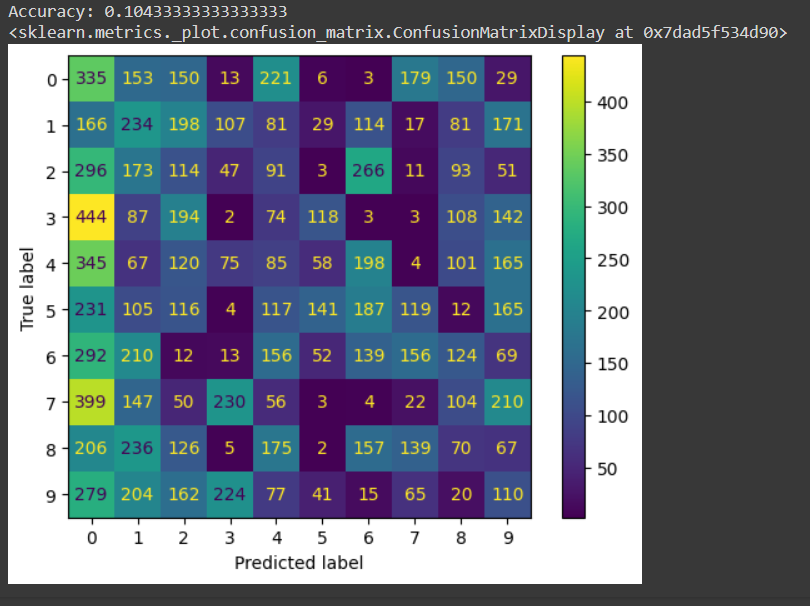

## Analysis

**Strengths:**

RBF Networks are powerful for interpolation and work well with small datasets.
They can approximate any continuous function given enough centers.

**Limitations:**

- They are sensitive to the number of centers (RBF units).
- Training can be computationally expensive with large datasets.
- Overfitting is a risk if too many centers are used.

**Effect of the Number of RBF Units:**

- Increasing the number of RBF units allows the model to capture more complex patterns, but too many units may lead to overfitting.
- Fewer RBF units may generalize better, but the model might miss important details in the data.

**Conclusion:**

The RBF network provides a flexible way to classify images in the Kuzushiji dataset, but the performance can vary depending on the number of centers and proper tuning of hyperparameters such as learning rate and the number of epochs.